In [1]:
import numpy as np
import glob
import torch
from torch.utils.data import DataLoader, random_split
from gan_utils.io import VeritasDataGen, VeritasDataGenNorm, StereoVeristasDataGenNorm
import matplotlib.pyplot as plt
from torchinfo import summary
import tqdm
from gan.model import Generator, Discriminator, Encoder, DiscriminatorFeatures

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
gen_model = Generator(n_z=256, input_filt=256, final_size=96, out_channels=4, norm=False, pool=False).to(device)
# disc_model = Discriminator(in_channels=4, input_size=96, n_layers=4).to(device)
enc_model = Encoder(in_channels=4, n_z=256, n_layers=5, input_size=96, norm=False, pool=False).to(device)

In [4]:
if device == 'cuda':
    gen_model.load_state_dict(torch.load('./checkpoints_norm_stereo_NAdam_1e4/generator_ep_500.pth'))
#     disc_model.load_state_dict(torch.load('./checkpoints_norm_stereo/discriminator_ep_130.pth'))
    enc_model.load_state_dict(torch.load('./checkpoints_encoder_norm_NAdam_1e4/encoder_ep_500.pth'))
else:
    gen_model.load_state_dict(torch.load('./checkpoints_norm_stereo/generator_ep_300.pth', map_location='cpu'))
#     enc_model.load_state_dict(torch.load('./checkpoints_norm/encoder_ep_150.pth', map_location='cpu'))

In [5]:
# veritas_data = VeritasDataGenNorm(input_file = "/home/manth145/data/Gamma_Hadron/71802_dl1_full.h5", size_threshold=1000)
# veritas_data = VeritasDataGenNorm(input_file = "/d1/manth145/Gamma_Hadron/simulation_dl1_full.h5", size_threshold=1000)
veritas_data = StereoVeristasDataGenNorm(input_file = "/home/fortson/manth145/data/Veritas/71802_dl1_full.h5", 
                                         size_threshold=1000, mode='intersect')
# veritas_data = StereoVeristasDataGenNorm(input_file = "/home/fortson/manth145/data/Veritas/71802_dl1_full.h5", 
#                                          size_threshold=1000)

train_val_split = 0.9
batch_size = 16
nworkers = 4

Found total samples 99918 meeting size thresh 1000


In [6]:
dataloader = DataLoader(veritas_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=nworkers, persistent_workers=True)

torch_rand_gen = torch.Generator().manual_seed(9999)
train_datagen, val_datagen = random_split(veritas_data, [train_val_split, 1 - train_val_split], generator=torch_rand_gen)


train_data = DataLoader(train_datagen, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=nworkers, persistent_workers=True)
val_data = DataLoader(val_datagen, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=nworkers, persistent_workers=True)


In [13]:
input_images = next(iter(train_data))

In [14]:
z_samp = torch.randn((5, 256), device=device)
gen_imgs = gen_model(z_samp).detach().cpu().numpy()

In [15]:
z_enc = enc_model(input_images.to(device))
enc_gen_imgs = gen_model(z_enc).detach().cpu().numpy()

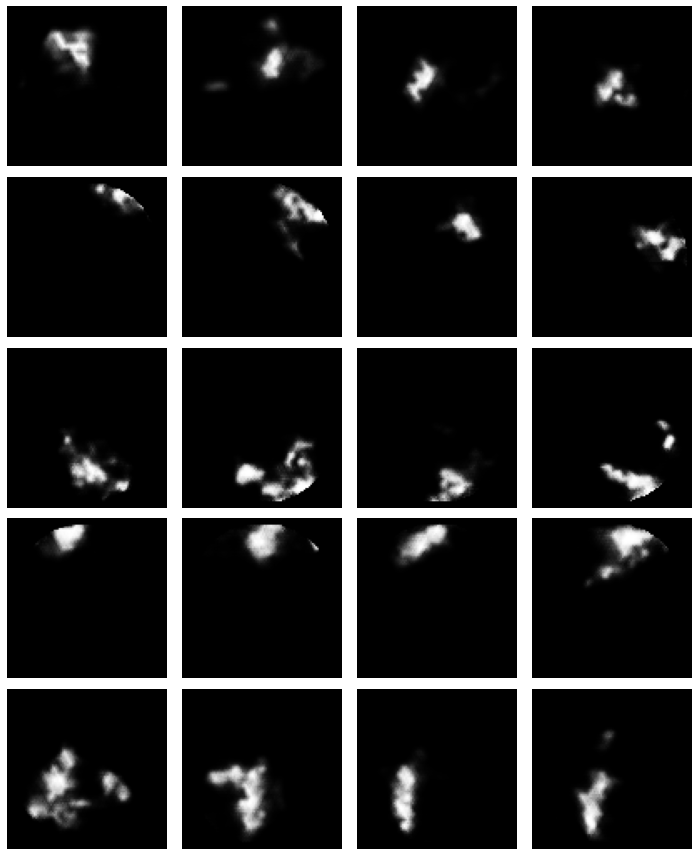

In [16]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[10,12])
for nrow in range(5):
    for tel in range(4):
        axs[nrow][tel].imshow(gen_imgs[nrow,tel,:,:], cmap='gray')
        axs[nrow][tel].axis('off')
# for i, ax in enumerate(axs):
#     ax.imshow(input_images[i,0,:,:], cmap='gray', vmin=0, vmax=1)
#     ax.axis('off')

plt.tight_layout()
plt.show()

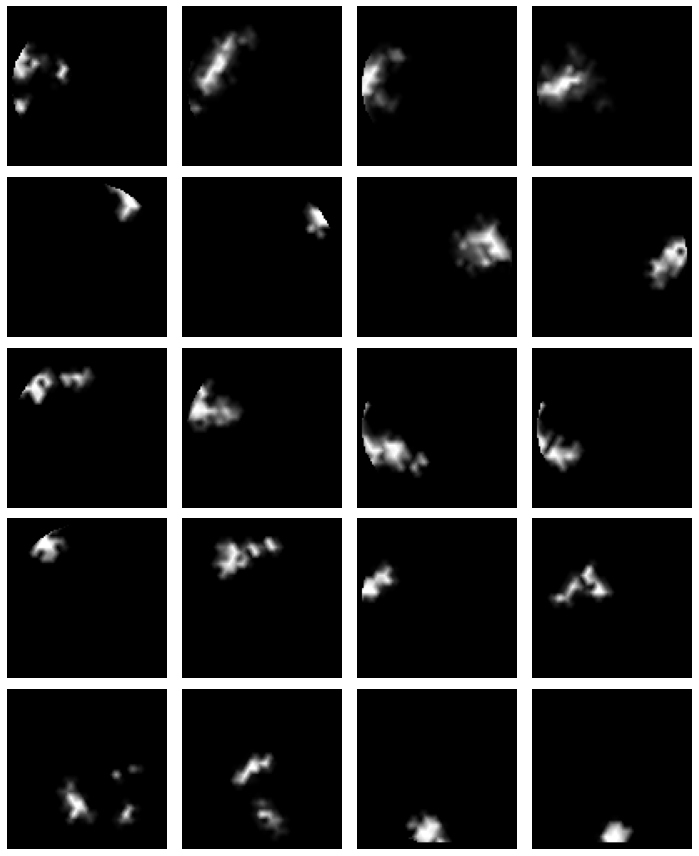

In [17]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[10,12])
for nrow in range(5):
    for tel in range(4):
        axs[nrow][tel].imshow(input_images[nrow,tel,:,:], cmap='gray', vmin=0, vmax=1)
        axs[nrow][tel].axis('off')
# for i, ax in enumerate(axs):
#     ax.imshow(input_images[i,0,:,:], cmap='gray', vmin=0, vmax=1)
#     ax.axis('off')
plt.tight_layout()
plt.show()

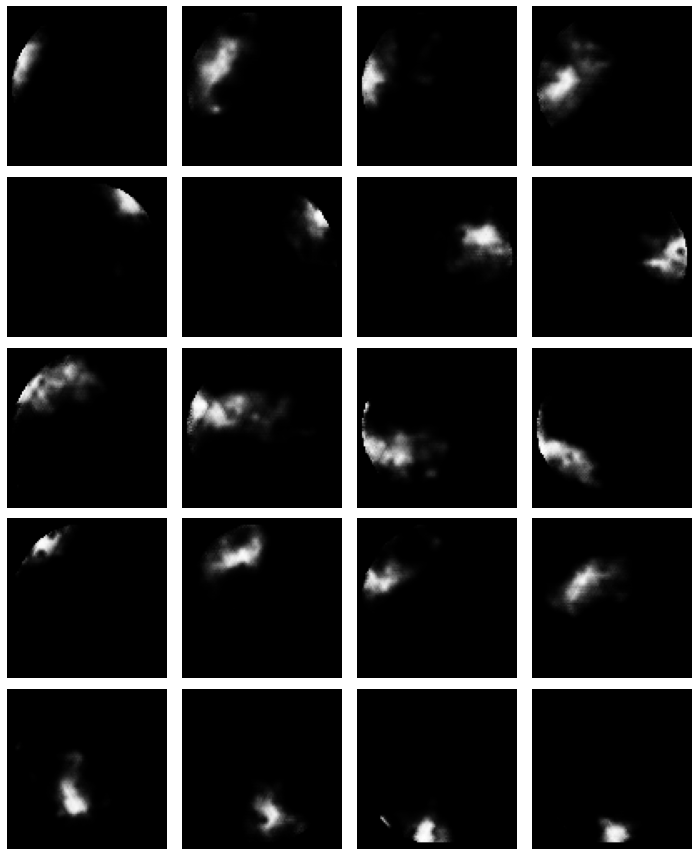

In [19]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=[10,12])
for nrow in range(5):
    for tel in range(4):
        axs[nrow][tel].imshow(enc_gen_imgs[nrow,tel,:,:], cmap='gray', vmin=0, vmax=1)
        axs[nrow][tel].axis('off')
# for i, ax in enumerate(axs):
#     ax.imshow(input_images[i,0,:,:], cmap='gray', vmin=0, vmax=1)
#     ax.axis('off')
plt.tight_layout()
plt.show()

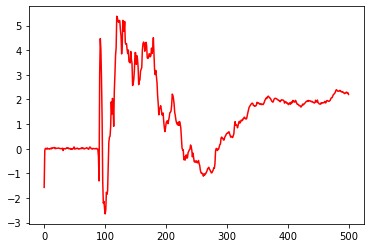

In [20]:
g_loss, d_loss = np.load('./checkpoints_norm_stereo_NAdam_1e4/loss_values.npy')
fig = plt.figure()
plt.plot(g_loss, linestyle='-', color='red', marker='None')

plt.show()

In [7]:
# disc_gen = disc_model(gen_model(z_samp).detach())

In [8]:
# disc_gen

tensor([[-12.1415],
        [  1.6308],
        [ -4.4289],
        [-10.5123],
        [ -8.4631]], device='cuda:0', grad_fn=<AddmmBackward0>)

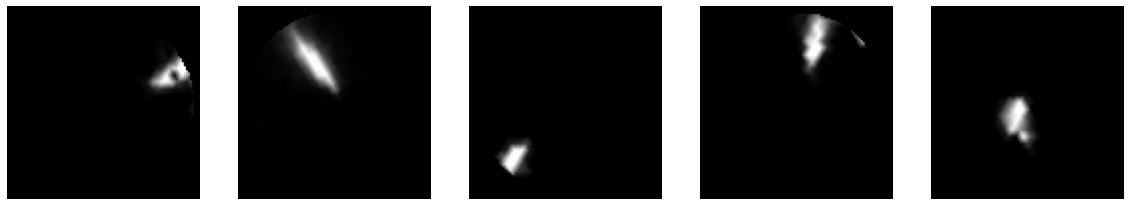

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=[20,8])
for i, ax in enumerate(axs):
    ax.imshow(input_images[i,0,:,:], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.show()

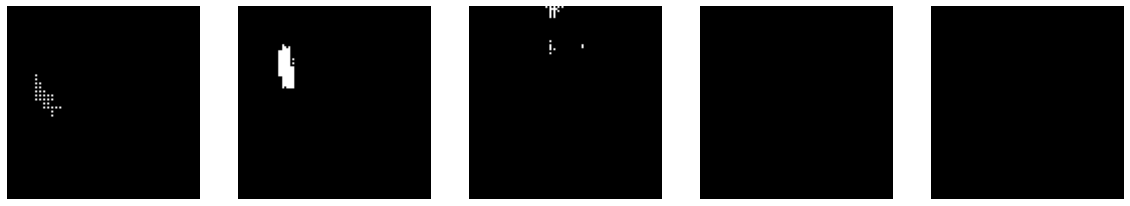

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=[20,8])
for i, ax in enumerate(axs):
    ax.imshow(gen_imgs[i,0,:,:], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.show()

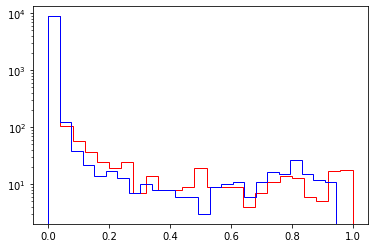

In [11]:
plt.hist(input_images[0,0,:,:].cpu().numpy().flat, bins=25, color='red', histtype='step')

plt.hist(gen_imgs[0,0,:,:].flat, bins=25, color='blue', histtype='step')

plt.yscale('log')

In [21]:
np.percentile(input_images[3,0,:,:].cpu().numpy().flat, 99)

0.4117710754275325

In [17]:
np.max(input_images[4,0,:,:].cpu().numpy().flat)

0.99656296

In [10]:
something = input_images

In [14]:
(torch.sum(input_images, dim=(2,3)).cpu().numpy() == 0).any()

False

In [17]:
for itern in tqdm.tqdm(range(train_data.__len__())):
    some_data = next(iter(train_data))
    extracted_data = torch.sum(some_data, dim=(2,3)).cpu().numpy()
    if (extracted_data == 0).any():
        print('Broken')
        break

  0%|▎                                                                                            | 17/5621 [00:27<2:29:42,  1.60s/it]

Broken


<function Tensor.__index__>

In [18]:
extracted_data

array([[111.5904  , 161.80804 , 107.71648 , 275.28586 ],
       [191.05574 , 240.48622 , 336.0341  , 320.4311  ],
       [462.7813  , 311.96875 , 331.85413 , 244.62292 ],
       [175.9764  , 281.28415 , 299.26868 , 414.68555 ],
       [  0.      , 117.85477 , 244.52657 , 339.66864 ],
       [300.9527  , 139.86507 , 175.87178 , 137.53943 ],
       [268.9434  , 370.12244 , 250.67311 , 367.23114 ],
       [322.68777 , 292.31445 , 335.8741  , 270.37302 ],
       [329.19513 , 278.22916 , 333.13916 , 303.13538 ],
       [273.99536 , 385.15237 , 357.9807  , 451.99365 ],
       [254.81357 , 317.9121  , 192.43141 , 126.821175],
       [180.53151 , 258.3341  , 202.54349 , 124.946304],
       [105.79961 , 297.6494  , 262.78647 , 221.07558 ],
       [249.89102 , 192.9864  , 247.83627 , 176.53223 ],
       [238.27734 , 215.36792 , 299.1629  , 237.01862 ],
       [189.36076 , 186.7922  , 172.2813  , 136.39421 ]], dtype=float32)

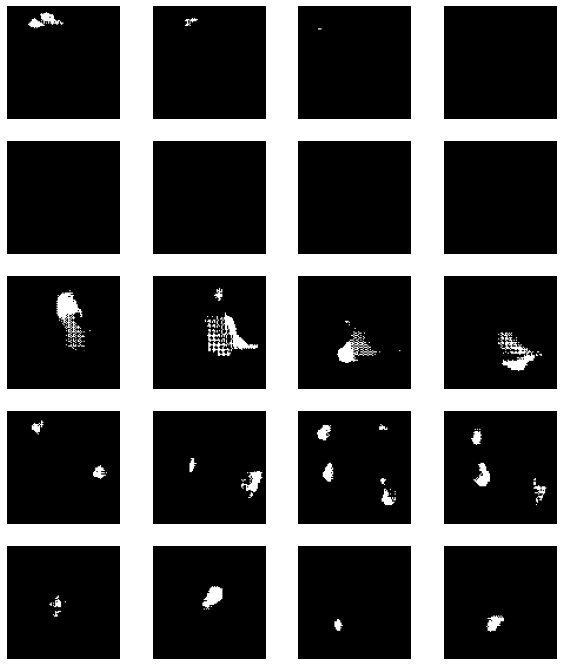

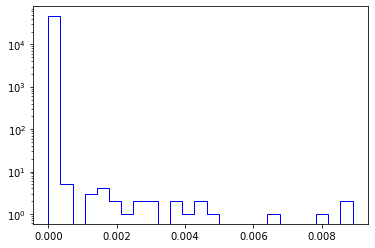

In [9]:
# plt.hist(input_images[:,2,:,:].cpu().numpy().flat, bins=25, color='red', histtype='step')

plt.hist(gen_imgs[:,2,:,:].flat, bins=25, color='blue', histtype='step')

plt.yscale('log')

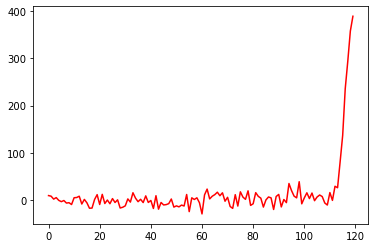

In [16]:
summary(gen_model, input_size=(1,512))

/usr/local/lib/python3.8/dist-packages/torchinfo/torchinfo.py:455: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Linear: 1-1                            [1, 2304]                 1,181,952
├─LeakyReLU: 1-2                         [1, 2304]                 --
├─Rearrange: 1-3                         [1, 256, 3, 3]            --
├─UpConvLayer: 1-4                       [1, 128, 6, 6]            --
│    └─ConvTranspose2d: 2-1              [1, 128, 6, 6]            1,179,776
│    └─LeakyReLU: 2-2                    [1, 128, 6, 6]            --
├─UpConvLayer: 1-5                       [1, 64, 12, 12]           --
│    └─ConvTranspose2d: 2-3              [1, 64, 12, 12]           294,976
│    └─LeakyReLU: 2-4                    [1, 64, 12, 12]           --
├─UpConvLayer: 1-6                       [1, 32, 24, 24]           --
│    └─ConvTranspose2d: 2-5              [1, 32, 24, 24]           73,760
│    └─LeakyReLU: 2-6                    [1, 32, 24, 24]      